In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_pickle('Hometask.pkl')

In [3]:
df.columns.tolist()

['id',
 'hobjId',
 'pdId',
 'region',
 'address',
 'objPublDt',
 'floorMin',
 'floorMax',
 'objElemLivingCnt',
 'objReady100PercDt',
 'wallMaterialShortDesc',
 'objLkFinishTypeCount',
 'objLkFreePlanDesc',
 'objElemParkingCnt',
 'objSquareLiving',
 'rpdNum',
 'rpdPdfLink',
 'rpdIssueDttm',
 'objLkLatitude',
 'objLkLongitude',
 'objCompensFundFlg',
 'objProblemFlg',
 'objLkClassDesc',
 'loadDttm',
 'photoRenderDTO',
 'objGuarantyEscrowFlg',
 'objectType',
 'miniUrl',
 'residentialBuildings',
 'newBuildingId',
 'objFloorCnt',
 'objFlatCnt',
 'objFlatSq',
 'objNonlivElemCnt',
 'objStatus',
 'isAvailableWantLiveHere',
 'objTransferPlanDt',
 'objLivCeilingHeight',
 'objInfrstrBicycleLaneFlg',
 'objInfrstrPlaygrndCnt',
 'objInfrstrSportGroundCnt',
 'objInfrstrTrashAreaCnt',
 'objInfrstrObjPrkngCnt',
 'objInfrstrNotObjPrkngCnt',
 'objInfrstrRampFlg',
 'objInfrstrCurbLoweringFlg',
 'objElevatorWheelchairCnt',
 'objElevatorPassengerCnt',
 'objElevatorCargoCnt',
 'objElevatorCargoPassengerCnt',


In [4]:
#Добавление названия региона
region = pd.read_excel('region.xlsx')

id_to_name = region.set_index('id').to_dict()['name']

df['reg'] = df['region'].map(id_to_name)

#Наличие метро
df['metro'] = df['metro.id'].fillna(-1).map(lambda x: 'Y' if float(x) > 0 else 'N' )

#Год постройки
df['objrdyear'] = pd.to_datetime(df.objReady100PercDt).dt.year

In [5]:
cols = ['reg','objPriceAvg','objFloorCnt','objSquareLiving','objFlatCnt','objElemParkingCnt','metro','objrdyear','wallMaterialShortDesc']

In [6]:
df_1 = df[cols]

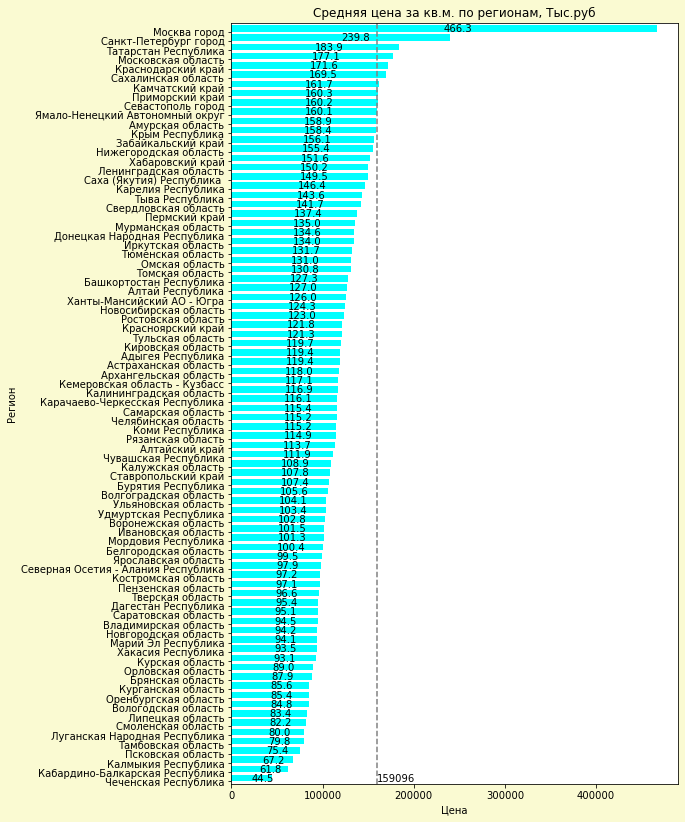

In [28]:
#Средняя стоимость кв. м. по регионам
ser_price = df_1.dropna(subset='objPriceAvg').groupby('reg')['objPriceAvg'].mean()

#Средние цены за кв. метр по регионам
avg = np.nanmean(df_1['objPriceAvg'])
plt.figure(figsize=(8,14), facecolor='#FAFAD2')
#sns.set_style("whitegrid")
ser_price.sort_values().plot(kind = 'barh',color = 'Cyan', align = 'edge', width = 0.7)
plt.title('Средняя цена за кв.м. по регионам, Тыс.руб')
plt.xlabel('Цена')
plt.ylabel('Регион')
plt.axvline(x = avg, color = 'grey', linestyle ='--')
plt.text(avg,0, str(round(avg)))
for i, v in enumerate(sorted(ser_price.values)):
    plt.text(v-v/2, i, str('{:.1f}'.format(v/1000)),fontsize = 10, color = 'Black')
plt.show()

<AxesSubplot:ylabel='objPriceAvg'>

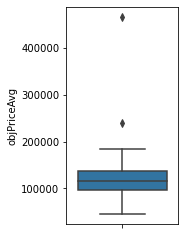

In [26]:
plt.figure(figsize=(2,4))
sns.boxplot(y = ser_price)

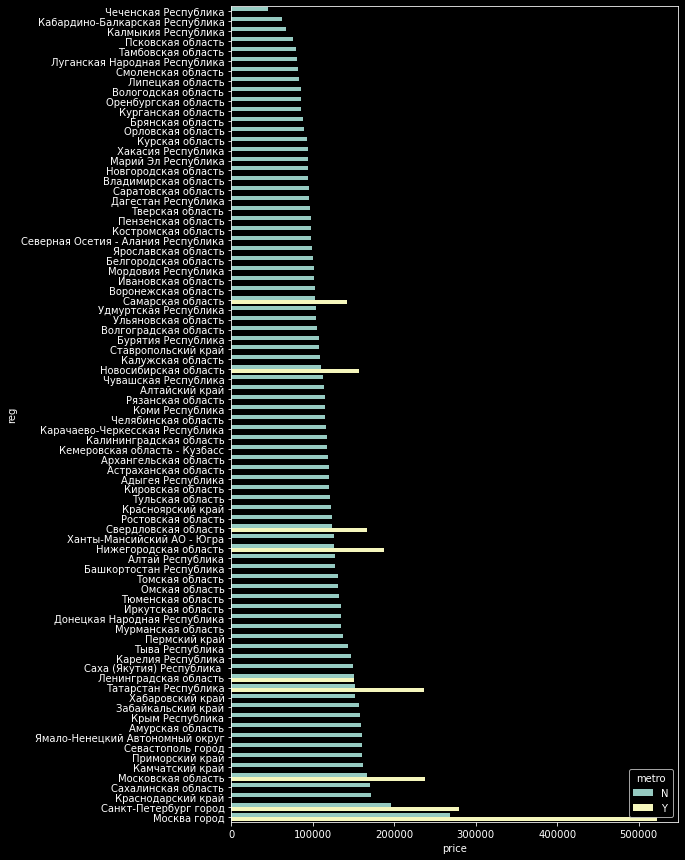

In [101]:
### Стоимость квартир с метро и без
df_metro = df_1.dropna(subset='objPriceAvg').groupby(['reg','metro']).mean()['objPriceAvg'].reset_index(name = 'price')
plt.figure(figsize=(8, 15))
sns.barplot(y = 'reg',
           x = 'price',
           hue = 'metro',
           data = df_metro.sort_values(by = 'price'))
plt.show()

Наибольшая стоимость жилья за кв. метр составляет 466 тыс. в городе Москва , наименьшая стоимоть жилья в Чеченской республике (44 тыс за кв.м.). Среняя цена по России составляет 159 т.р.Квартиры с непосредственной близости к метро существенно выше в цене(в г. Москва ~ в 2 раза выше).

In [8]:
#Количество вводимого жилья по регионам и годам
df_y_count = df_1.groupby('objrdyear').size()

df_reg_count = df_1.groupby('reg').size().reset_index(name = 'count')

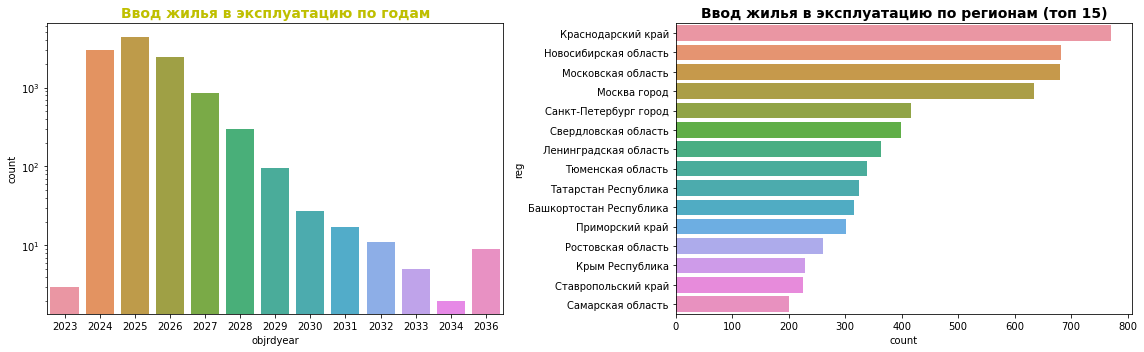

In [60]:
fig , (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
sns.countplot(
    x='objrdyear',
    data=df_1,
    log = True,
    ax = ax1)
ax1.set_title('Ввод жилья в эксплуатацию по годам', size=14, color='y', weight='bold')

sns.barplot(
    y = 'reg',
    x = 'count',
    data=df_reg_count.sort_values(by = 'count', ascending= False).head(15),
    ax = ax2)
ax2.set_title('Ввод жилья в эксплуатацию по регионам (топ 15)', size=14, color='black', weight='bold')
plt.tight_layout()
plt.show()

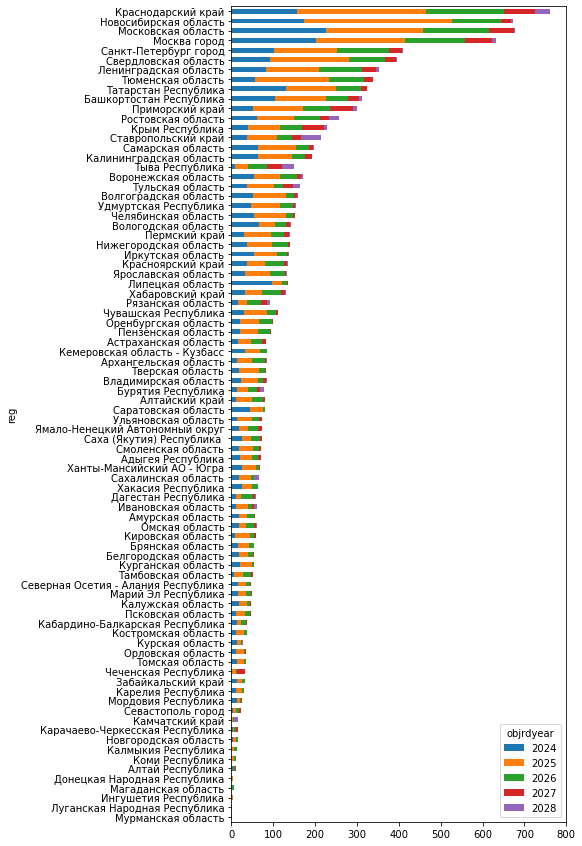

In [76]:
df_r = df.groupby(['reg','objrdyear']).size().reset_index(name ='count').\
pivot(index = 'reg', columns= 'objrdyear', values = 'count').fillna(0)

df_r['total'] = df_r.sum(axis= 1)

###Гистограмма с накоплением ввода жилья по регионам и годам
df_r.sort_values(by='total').drop('total',axis=1).loc[:,2024:2028].plot(kind = 'barh', stacked = True, figsize = (6,15))
plt.show()

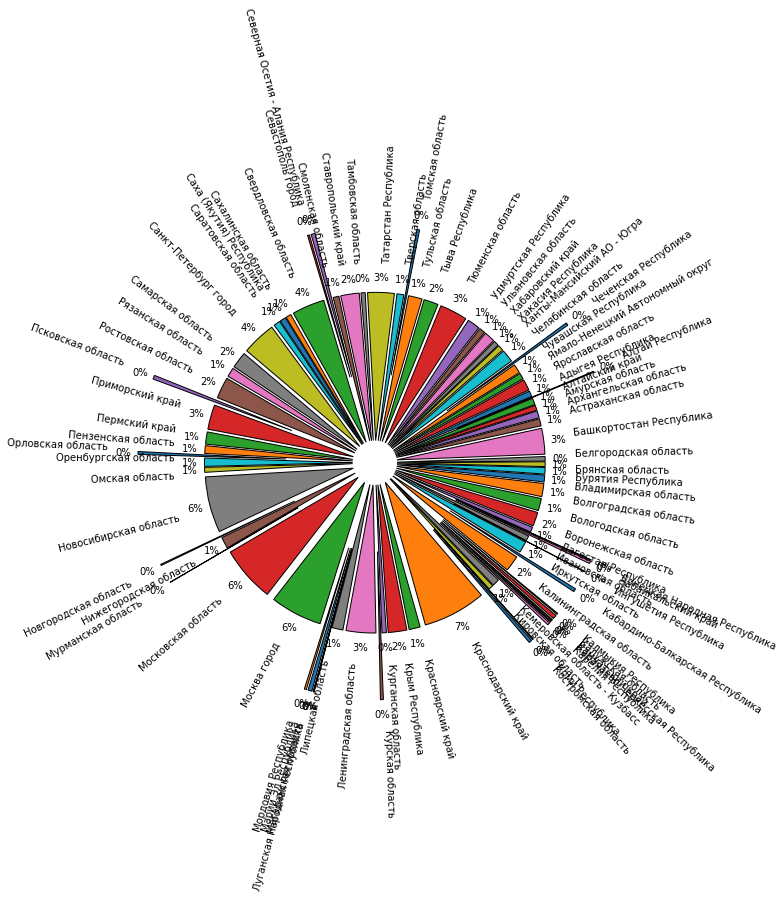

In [79]:
###Круговая даиграмма, доля ввода жилья по регионам
exp = [0.6 if i < 50 else 0.15 for i in df_reg_count['count']]
plt.figure(figsize=(15, 15), facecolor = 'White')
#plt.style.use('dark_background')
plt.pie(x = df_reg_count['count'],
        labels = df_reg_count['reg'],
        startangle= 25,
        explode = exp,
        autopct='%.0f%%',
        pctdistance= 1.1,
        labeldistance= 1.2,
        rotatelabels= True,
        counterclock= False,
       wedgeprops={'edgecolor':'black'})
plt.tight_layout()
plt.show()

Наибольшее  кол-во запланированных к сдаче объектов недвижимости приходится на 2025 год, далее наблюдается ежегодный спад до 2034 года. В топ 5 регионов по кол-ву строительству жилья входят:  Краснодарский край (7% доли рынка), Новосибирская  , Московкая области и  город Мосва занимают 6% рынка,  Санкт-Петербург занимает 4% рынка.

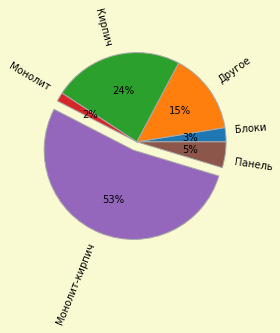

In [71]:
###Круговая диаграмма типа стен
df_types = df_1.groupby('wallMaterialShortDesc').count()['reg'].reset_index(name = 'count')
plt.figure(figsize=(4,10), facecolor='#FAFAD2')
plt.pie(
x = df_types['count'],
labels= df_types['wallMaterialShortDesc'],
autopct='%.0f%%',
explode = [0, 0 , 0 ,0 ,0.1 ,0],
rotatelabels= True,
wedgeprops={'edgecolor':'DarkGray'}
)
plt.show()

Около 53% всех домов в России выполнены из монолит-кирпича, 24% выполнены из кирпича.

In [96]:
df_region = df.query('region in [25,27,50,23]')[cols]

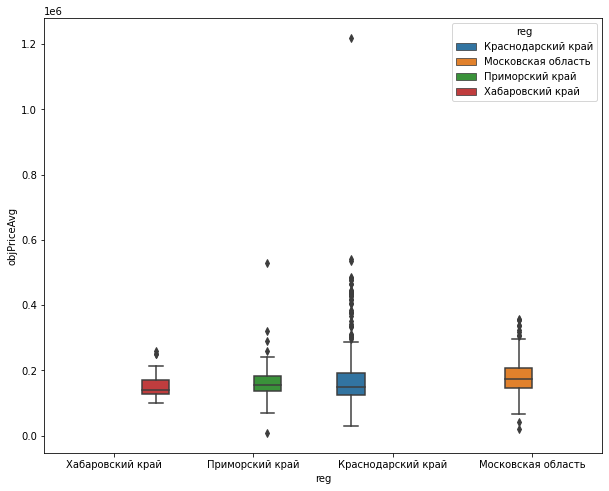

In [86]:
###Средняя цена за кв.м по регионам
plt.figure(figsize=(10,8))
sns.boxplot(
    y = 'objPriceAvg',
    x = 'reg',
    hue = 'reg',
    order = ['Хабаровский край','Приморский край','Краснодарский край','Московская область'],
    data = df_region.dropna(subset='objPriceAvg'))
plt.show()

In [90]:
col = ['objFloorCnt','objSquareLiving','objFlatCnt','objElemParkingCnt']

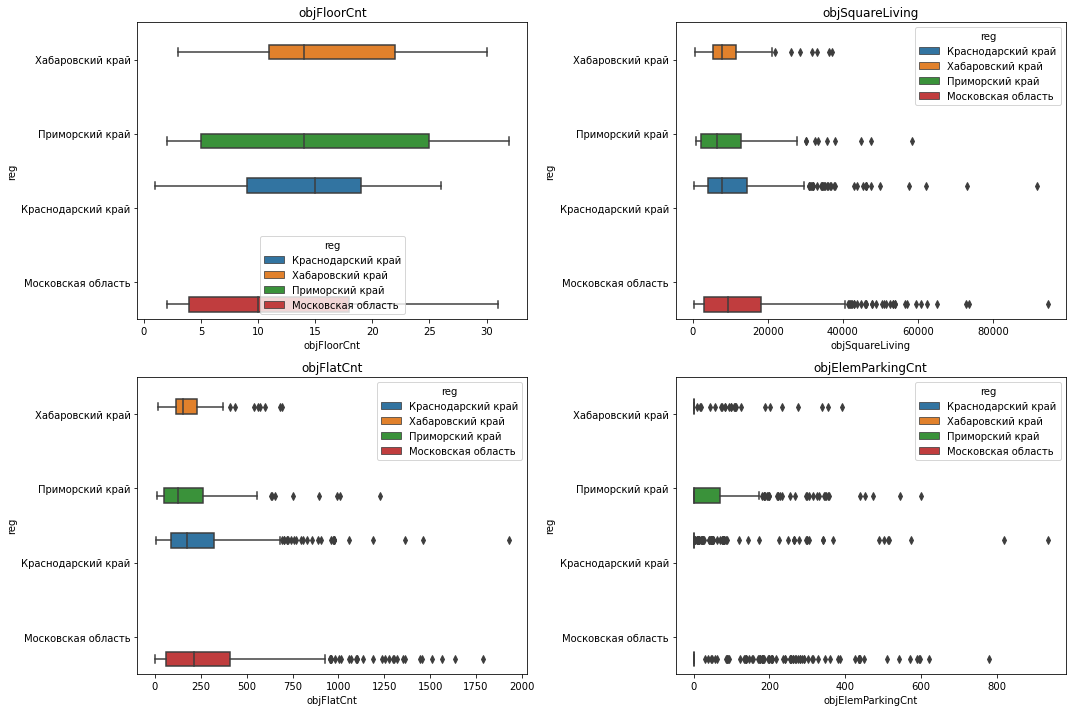

In [97]:
plt.figure(figsize=(15, 10))
for idx, feature in enumerate(col, 1):
    plt.subplot(2, 2, idx)
    sns.boxplot(
        y = 'reg',
        x = feature,
        hue = 'reg',
        order = ['Хабаровский край','Приморский край','Краснодарский край','Московская область'],
        data = df_region)
    plt.title(f"{feature}")
plt.tight_layout()
plt.show()

На графиках показаны данные по следующим регионам: Хабаровский край,Приморский край,Краснодарский край,Московская область. Наивысшая стоимость жилья наблюается в МО, наименшая в Хабаровской крайе. Набольшей вариативностью отличается Краснодарский край(большой диапазон цен на жилье).
Наибольшее кол-во квартир и жилой площади в новостройках наблюдется в МО, этажность домов самая высокая в Примоском крае. 

C:\Users\quel\AppData\Local\Temp\ipykernel_8660\3136555560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.metro = df_1.metro.replace({'N':0,'Y':1})


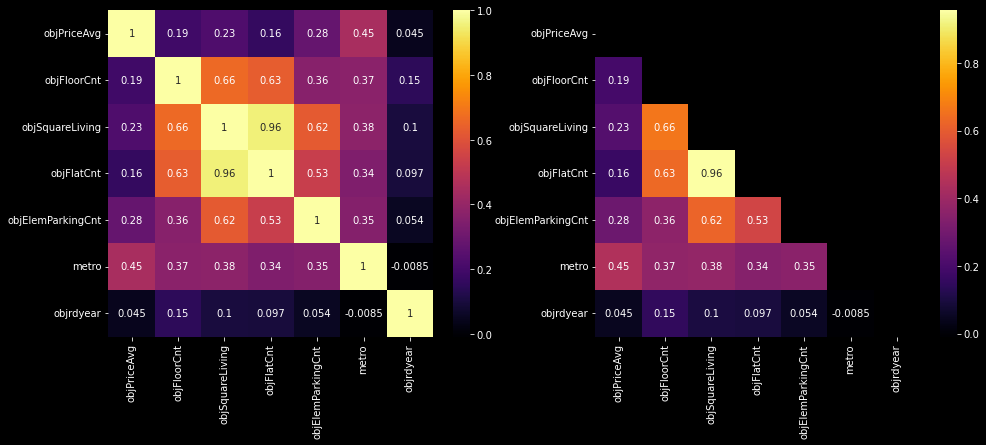

In [106]:
df_1.metro = df_1.metro.replace({'N':0,'Y':1})
matrix = np.triu(df_1.corr())
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))
sns.heatmap(
    df_1.corr(),
    annot=True,
    fmt = '.2g',
    cmap= 'inferno',
    ax = ax1
#mask= matrix
)
sns.heatmap(
    df_1.corr(),
    annot=True,
    fmt = '.2g',
    cmap= 'inferno',
    ax = ax2,
    mask= matrix
)
plt.show()

Существует прямая зависимость между ценой на квартру и наличием рядом метро, а также наличием парковочных мест. 